## Data collection

In [3]:
import os
import json
import random
import requests

In [4]:
words_file_path = 'georgian_words.txt'
all_words_list = []

if os.path.exists(words_file_path):
    with open(words_file_path, 'r', encoding = 'utf-8') as f:
        content = f.read()

    all_words_list = [w for w in content.split(',') if w]
    print('georgian_words.txt already exists')
else:
    words1 = set()
    url_comma_txt = 'https://raw.githubusercontent.com/eymenefealtun/all-words-in-all-languages/main/Georgian/Georgian.txt'

    response = requests.get(url_comma_txt)

    for word in response.text.split(','):
        word = word.strip()
        if word:
            words1.add(word)

    words2 = set()
    json_urls = [
        'https://raw.githubusercontent.com/AleksandreSukh/GeorgianWordsDataBase/master/wordsChunk_0.json',
        'https://raw.githubusercontent.com/AleksandreSukh/GeorgianWordsDataBase/master/wordsChunk_1.json',
        'https://raw.githubusercontent.com/AleksandreSukh/GeorgianWordsDataBase/master/wordsChunk_2.json',
    ]

    for url in json_urls:
        response = requests.get(url)
        words = json.loads(response.text)
        for word in words:
            words2.add(word)

    all_words = words1 & words2

    all_words = {
        word for word in all_words if
        len(word) > 2 and
        all("ა" <= ch <= "ჰ" for ch in word)
    }

    grouped = {}
    for w in all_words:
        first = w[0]
        if first not in grouped:
            grouped[first] = []
        grouped[first].append(w)

    reduced_words = []
    for first, group in grouped.items():
        k = max(1, int(len(group) * 0.3))
        random.shuffle(group)
        reduced_words.extend(group[:k])

    all_words_list = sorted(reduced_words)

    print()
    print("Total unique Georgian words:", len(all_words_list))

    with open(words_file_path, 'w', encoding = 'utf-8') as f:
        f.write(','.join(all_words_list))

    print('Saved georgian_words.txt')

print("Total unique Georgian words:", len(all_words_list))


georgian_words.txt already exists
Total unique Georgian words: 23162


## Data Preparation

To generate incorrect words, three types of typos are simulated:

1. **Keyboard typos** - Characters are replaced with neighboring keys based on the Georgian keyboard layout, including accidental 'Backspace' and 'Shift' key errors

2. **Character swaps** - Adjacent characters are transposed to simulate typing out of sequence

3. **Character doubling** - Characters are duplicated to simulate pressing a key twice

In [5]:
# map of neighboring georgian letters on a standard keyboard. None = Backspace, e. g. skip current
georgian_keyboard_map = [
    ['ქ', 'წჭ', 'ე', 'რღ', 'ტთ', 'ყ', 'უ', 'ი', 'ო', 'პ'],
    ['ა', 'სშ', 'დ', 'ფ', 'გ', 'ჰ', 'ჯჟ', 'კ', 'ლ', None],
    ['ზძ', 'ხ', 'ცჩ', 'ვ', 'ბ', 'ნ', 'მ', None, None, None],
]

n, m = len(georgian_keyboard_map), len(georgian_keyboard_map[0])

dirs = [
    (-1, -1), (-1, 0), (-1, 1),
    ( 0, -1), ( 0, 0), ( 0, 1),
    ( 1, -1), ( 1, 0), ( 1, 1),
]

step_probabilities = [
    0.00005, 0.00020, 0.00005,
    0.00020, 0.99900, 0.00020,
    0.00005, 0.00200, 0.00005,
]

In [6]:
def keyboard_typo(word, shift_change_prob = 0.05):
    char_to_pos = {}

    for i, row in enumerate(georgian_keyboard_map):
        for j, cell in enumerate(row):
            if cell is not None:
                for shift_idx, char in enumerate(cell):
                    char_to_pos[char] = (i, j, shift_idx)
    
    corrupted_chars = []
    
    for char in word:
        if char not in char_to_pos:
            corrupted_chars.append(char)
            continue
        
        row, col, shift_idx = char_to_pos[char]
        
        direction_idx = random.choices(range(len(dirs)), weights = step_probabilities)[0]
        dr, dc = dirs[direction_idx]
        
        new_row = row + dr
        new_col = col + dc
        
        if 0 <= new_row < n and 0 <= new_col < m:
            target_cell = georgian_keyboard_map[new_row][new_col]
            
            if target_cell is None:  # None = Backspace = skip
                continue

            if random.random() < shift_change_prob and len(target_cell) > 1:
                new_shift_idx = 1 - shift_idx if shift_idx < 2 else 0
                new_shift_idx = min(new_shift_idx, len(target_cell) - 1)
            else:
                new_shift_idx = min(shift_idx, len(target_cell) - 1)
            
            corrupted_chars.append(target_cell[new_shift_idx])
        else:
            corrupted_chars.append(char)
    
    return ''.join(corrupted_chars)

def swap_adjacent_chars(word, swap_prob = 0.005):
    chars = list(word)
    current_prob = swap_prob
    i = 0
    
    while i < len(chars) - 1:
        if random.random() < current_prob:
            chars[i], chars[i + 1] = chars[i + 1], chars[i]
            current_prob /= 10 # decrease probability for less swaps
            i += 2
        else:
            i += 1
    
    return ''.join(chars)

def double_char(word, double_prob = 0.005):
    chars = []
    current_prob = double_prob
    
    for char in word:
        chars.append(char)
        if random.random() < current_prob:
            chars.append(char)
            current_prob /= 10 # decrease probability for less duplications
    
    return ''.join(chars)

def corrupt_word(word, shift_change_prob = 0.05, swap_prob = 0.005, double_prob = 0.005):
    word = keyboard_typo(word, shift_change_prob)
    word = swap_adjacent_chars(word, swap_prob)
    word = double_char(word, double_prob)
    return word

# function that returns edit distance (Levenshtein distance) between two words
def edit_distance(a, b):
    n, m = len(a), len(b)
    dp = [[0] * (m + 1) for _ in range(n + 1)]

    for i in range(n + 1):
        dp[i][0] = i
    for j in range(m + 1):
        dp[0][j] = j

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            if a[i - 1] == b[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]
            else:
                dp[i][j] = 1 + min(dp[i - 1][j], dp[i][j - 1], dp[i - 1][j - 1])

    return dp[n][m]

In [7]:
random.seed(42)

correct_pairs = []
incorrect_pairs = []

max_incorrect_per_word = 5
max_attempts_per_word = 20

for word in all_words_list:
    correct_pairs.append((word, word))

    per_word_incorrect = 0
    attempts = 0

    while per_word_incorrect < max_incorrect_per_word and attempts < max_attempts_per_word:
        corrupted = corrupt_word(word)
        attempts += 1

        if corrupted == word:
            continue

        d = edit_distance(corrupted, word)
        if d == 1 or d == 2:
            incorrect_pairs.append((corrupted, word))
            per_word_incorrect += 1

pairs = correct_pairs + incorrect_pairs

In [8]:
all_input_chars = set()
all_target_chars = set()

for corrupted, correct in pairs:
    all_input_chars.update(list(corrupted))
    all_target_chars.update(list(correct))

all_chars = sorted(all_input_chars | all_target_chars)

PAD_TOKEN = '<pad>'
SOS_TOKEN = '<sos>'
EOS_TOKEN = '<eos>'
UNK_TOKEN = '<unk>'

special_tokens = [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN, UNK_TOKEN]
itos = special_tokens + all_chars
stoi = {ch: idx for idx, ch in enumerate(itos)}

vocab_size = len(itos)
pad_idx = stoi[PAD_TOKEN]
sos_idx = stoi[SOS_TOKEN]
eos_idx = stoi[EOS_TOKEN]
unk_idx = stoi[UNK_TOKEN]

print('Vocab size:', vocab_size) # should be 33 + 4 special tokens = 37
print('Tokens:', itos)

Vocab size: 37
Tokens: ['<pad>', '<sos>', '<eos>', '<unk>', 'ა', 'ბ', 'გ', 'დ', 'ე', 'ვ', 'ზ', 'თ', 'ი', 'კ', 'ლ', 'მ', 'ნ', 'ო', 'პ', 'ჟ', 'რ', 'ს', 'ტ', 'უ', 'ფ', 'ქ', 'ღ', 'ყ', 'შ', 'ჩ', 'ც', 'ძ', 'წ', 'ჭ', 'ხ', 'ჯ', 'ჰ']


## Training

In [9]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [10]:
def encode_word(word, add_eos = True):
    indices = []
    for ch in word:
        indices.append(stoi.get(ch, unk_idx))
    if add_eos:
        indices.append(eos_idx)
    return indices

def decode_indices(indices):
    chars = []
    for idx in indices:
        if idx == eos_idx or idx == pad_idx:
            break
        chars.append(itos[idx])
    return ''.join(chars)

encoded_correct_pairs = []
encoded_incorrect_pairs = []
max_input_len = 0
max_target_len = 0

for corrupted, correct in correct_pairs:
    src_indices = encode_word(corrupted, add_eos = True)
    tgt_indices = [sos_idx] + encode_word(correct, add_eos = True)

    encoded_correct_pairs.append((src_indices, tgt_indices))

    if len(src_indices) > max_input_len:
        max_input_len = len(src_indices)
    if len(tgt_indices) > max_target_len:
        max_target_len = len(tgt_indices)

for corrupted, correct in incorrect_pairs:
    src_indices = encode_word(corrupted, add_eos = True)
    tgt_indices = [sos_idx] + encode_word(correct, add_eos = True)

    encoded_incorrect_pairs.append((src_indices, tgt_indices))

    if len(src_indices) > max_input_len:
        max_input_len = len(src_indices)
    if len(tgt_indices) > max_target_len:
        max_target_len = len(tgt_indices)

print('Total correct encoded pairs:', len(encoded_correct_pairs))
print('Total incorrect encoded pairs:', len(encoded_incorrect_pairs))
print('Max input length:', max_input_len)
print('Max target length:', max_target_len)

Total correct encoded pairs: 23162
Total incorrect encoded pairs: 70843
Max input length: 22
Max target length: 22


In [11]:
random.shuffle(encoded_incorrect_pairs)

val_ratio = 0.2
val_incorrect_count = int(len(encoded_incorrect_pairs) * val_ratio)

if val_incorrect_count == 0:
    train_incorrect_pairs = encoded_incorrect_pairs
    val_incorrect_pairs = []
else:
    train_incorrect_pairs = encoded_incorrect_pairs[:-val_incorrect_count]
    val_incorrect_pairs = encoded_incorrect_pairs[-val_incorrect_count:]

train_pairs = encoded_correct_pairs + train_incorrect_pairs
val_pairs = val_incorrect_pairs

print('Train size:', len(train_pairs))
print('Val size:', len(val_pairs))

Train size: 79837
Val size: 14168


In [12]:
class SpellcheckDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        src, tgt = self.pairs[idx]
        src_tensor = torch.tensor(src, dtype = torch.long)
        tgt_tensor = torch.tensor(tgt, dtype = torch.long)
        return src_tensor, tgt_tensor


def collate_fn(batch):
    src_seqs, tgt_seqs = zip(*batch)

    src_lengths = torch.tensor([len(seq) for seq in src_seqs], dtype = torch.long)
    tgt_lengths = torch.tensor([len(seq) for seq in tgt_seqs], dtype = torch.long)

    max_src_len = src_lengths.max().item()
    max_tgt_len = tgt_lengths.max().item()

    batch_size = len(batch)

    padded_src = torch.full((batch_size, max_src_len), pad_idx, dtype = torch.long)
    padded_tgt = torch.full((batch_size, max_tgt_len), pad_idx, dtype = torch.long)

    for i, (src, tgt) in enumerate(zip(src_seqs, tgt_seqs)):
        padded_src[i, : len(src)] = src
        padded_tgt[i, : len(tgt)] = tgt

    return padded_src, src_lengths, padded_tgt, tgt_lengths


batch_size = 128

train_dataset = SpellcheckDataset(train_pairs)
val_dataset = SpellcheckDataset(val_pairs)

train_loader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle = True,
    collate_fn = collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size = batch_size,
    shuffle = False,
    collate_fn = collate_fn
)

example_batch = next(iter(train_loader))
print('Batch shapes:')
for x in example_batch:
    print(x.shape)

Batch shapes:
torch.Size([128, 17])
torch.Size([128])
torch.Size([128, 17])
torch.Size([128])


In [13]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers = 1, dropout = 0.1):
        super().__init__()
        
        self.embedding = nn.Embedding(
            num_embeddings = vocab_size,
            embedding_dim = embedding_dim,
            padding_idx = pad_idx
        )

        self.gru = nn.GRU(
            input_size = embedding_dim,
            hidden_size = hidden_dim,
            num_layers = num_layers,
            batch_first = True,
            dropout = dropout if num_layers > 1 else 0.0,
            bidirectional = False
        )

    def forward(self, src: torch.Tensor, src_lengths: torch.Tensor):
        # src: (batch, src_len)
        embedded = self.embedding(src) # (batch, src_len, emb)

        packed = nn.utils.rnn.pack_padded_sequence(
            embedded,
            src_lengths.cpu(),
            batch_first = True,
            enforce_sorted = False
        )

        outputs, hidden = self.gru(packed)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs, batch_first = True)
        return outputs, hidden # outputs: (batch, src_len, hidden_dim), hidden: (num_layers, batch, hidden_dim)

In [14]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim

    def forward(self, hidden: torch.Tensor, encoder_outputs: torch.Tensor, src_lengths: torch.Tensor):
        # hidden: (num_layers, batch, hidden_dim) we use last layer
        # encoder_outputs: (batch, src_len, hidden_dim)
        batch_size, src_len, hidden_dim = encoder_outputs.size()

        query = hidden[-1] # (batch, hidden_dim)
        scores = torch.bmm(encoder_outputs, query.unsqueeze(2)).squeeze(2) # (batch, src_len)

        device_scores = scores.device
        index_range = torch.arange(src_len, device = device_scores).unsqueeze(0)
        mask = index_range >= src_lengths.unsqueeze(1)
        scores = scores.masked_fill(mask, float('-inf'))

        attn_weights = torch.softmax(scores, dim = 1) # (batch, src_len)
        context = torch.bmm(attn_weights.unsqueeze(1),encoder_outputs).squeeze(1) # (batch, hidden_dim)

        return context, attn_weights

In [15]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers = 1, dropout = 0.1):
        super().__init__()
        
        self.embedding = nn.Embedding(
            num_embeddings = vocab_size,
            embedding_dim = embedding_dim,
            padding_idx = pad_idx
        )

        self.attention = Attention(hidden_dim)

        self.gru = nn.GRU(
            input_size = embedding_dim + hidden_dim,
            hidden_size = hidden_dim,
            num_layers = num_layers,
            batch_first = True,
            dropout = dropout if num_layers > 1 else 0.0
        )

        self.fc_out = nn.Linear(
            in_features = hidden_dim * 2,
            out_features = vocab_size
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, input_step: torch.Tensor, hidden: torch.Tensor, encoder_outputs: torch.Tensor, src_lengths: torch.Tensor):
        # input_step: (batch, )
        embedded = self.dropout(self.embedding(input_step)) # (batch, emb)
        embedded = embedded.unsqueeze(1) # (batch, 1, emb)

        context, attn_weights = self.attention(hidden, encoder_outputs, src_lengths)
        context = context.unsqueeze(1) # (batch, 1, hidden)

        rnn_input = torch.cat([embedded, context], dim = 2) # (batch, 1, emb + hidden)

        output, hidden = self.gru(rnn_input, hidden)
        output = output.squeeze(1) # (batch, hidden)
        context = context.squeeze(1) # (batch, hidden)

        concat = torch.cat([output, context], dim = 1) # (batch, hidden * 2)
        logits = self.fc_out(concat) # (batch, vocab_size)

        return logits, hidden, attn_weights

In [16]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder: Encoder, decoder: Decoder, sos_idx, eos_idx, pad_idx, max_target_len):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.sos_idx = sos_idx
        self.eos_idx = eos_idx
        self.pad_idx = pad_idx
        self.max_target_len = max_target_len

    def forward(self, src: torch.Tensor, src_lengths: torch.Tensor, tgt: torch.Tensor | None = None, teacher_forcing_ratio = 0.5):
        batch_size = src.size(0)
        encoder_outputs, hidden = self.encoder(src, src_lengths)
        device_local = src.device

        if tgt is not None:
            max_len = tgt.size(1)
        else:
            max_len = self.max_target_len

        outputs = torch.zeros(batch_size, max_len, vocab_size, device = device_local)

        input_step = torch.full((batch_size,), self.sos_idx, dtype = torch.long, device = device_local)

        for t in range(max_len):
            logits, hidden, _ = self.decoder(input_step, hidden, encoder_outputs, src_lengths)
            outputs[:, t, :] = logits

            if tgt is not None and t + 1 < max_len and random.random() < teacher_forcing_ratio:
                input_step = tgt[:, t + 1]
            else:
                input_step = logits.argmax(dim = 1)

        return outputs

In [17]:
embedding_dim = 64
hidden_dim = 256
num_layers = 1
dropout = 0.1

encoder = Encoder(
    vocab_size = vocab_size,
    embedding_dim = embedding_dim,
    hidden_dim = hidden_dim,
    num_layers = num_layers,
    dropout = dropout
)

decoder = Decoder(
    vocab_size = vocab_size,
    embedding_dim = embedding_dim,
    hidden_dim = hidden_dim,
    num_layers = num_layers,
    dropout = dropout
)

model = Seq2Seq(
    encoder = encoder,
    decoder = decoder,
    sos_idx = sos_idx,
    eos_idx = eos_idx,
    pad_idx = pad_idx,
    max_target_len = max_target_len
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index = pad_idx)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

print(model)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(37, 64, padding_idx=0)
    (gru): GRU(64, 256, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(37, 64, padding_idx=0)
    (attention): Attention()
    (gru): GRU(320, 256, batch_first=True)
    (fc_out): Linear(in_features=512, out_features=37, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)


In [18]:
num_epochs = 20
teacher_forcing_ratio = 0.5
patience = 3

best_val_loss = float('inf')
epochs_without_improvement = 0

train_losses = []
val_losses = []

for epoch in range(1, num_epochs + 1):
    model.train()
    total_train_loss = 0.0

    for src_batch, src_lengths, tgt_batch, tgt_lengths in train_loader:
        src_batch = src_batch.to(device)
        src_lengths = src_lengths.to(device)
        tgt_batch = tgt_batch.to(device) # (batch, tgt_len)

        optimizer.zero_grad()

        outputs = model(src = src_batch, src_lengths = src_lengths, tgt = tgt_batch, teacher_forcing_ratio = teacher_forcing_ratio) # (batch, tgt_len, vocab_size)
        output_dim = outputs.size(-1)

        # shift by one, we predict token t + 1 at step t
        outputs_flat = outputs[:, :-1, :].contiguous().view(-1, output_dim)
        targets_flat = tgt_batch[:, 1:].contiguous().view(-1)

        loss = criterion(outputs_flat, targets_flat)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for src_batch, src_lengths, tgt_batch, tgt_lengths in val_loader:
            src_batch = src_batch.to(device)
            src_lengths = src_lengths.to(device)
            tgt_batch = tgt_batch.to(device)

            outputs = model(src = src_batch,src_lengths = src_lengths, tgt = tgt_batch, teacher_forcing_ratio = 0.0)
            output_dim = outputs.size(-1)
            outputs_flat = outputs[:, :-1, :].contiguous().view(-1, output_dim)
            targets_flat = tgt_batch[:, 1:].contiguous().view(-1)

            loss = criterion(outputs_flat, targets_flat)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch:02d}: train loss {avg_train_loss:.4f}, val loss {avg_val_loss:.4f}')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0

        checkpoint = {
            'model_state_dict': model.state_dict(),
            'vocab': {
                'itos': itos,
                'stoi': stoi,
                'pad_idx': pad_idx,
                'sos_idx': sos_idx,
                'eos_idx': eos_idx,
                'unk_idx': unk_idx
            },
            'config': {
                'embedding_dim': embedding_dim,
                'hidden_dim': hidden_dim,
                'num_layers': num_layers,
                'dropout': dropout,
                'max_target_len': max_target_len
            }
        }

        torch.save(checkpoint, 'georgian_spellcheck_seq2seq.pt')
        print('Saved new best model')
    else:
        epochs_without_improvement += 1
        print('No improvement, patience:', epochs_without_improvement)
        
        if epochs_without_improvement >= patience:
            print('Early stopping')
            break

Epoch 01: train loss 0.8791, val loss 0.5919
Saved new best model
Epoch 02: train loss 0.3163, val loss 0.4933
Saved new best model
Epoch 03: train loss 0.2763, val loss 0.4587
Saved new best model
Epoch 04: train loss 0.2463, val loss 0.4140
Saved new best model
Epoch 05: train loss 0.2308, val loss 0.4240
No improvement, patience: 1
Epoch 06: train loss 0.2211, val loss 0.4121
Saved new best model
Epoch 07: train loss 0.2051, val loss 0.3988
Saved new best model
Epoch 08: train loss 0.1973, val loss 0.4062
No improvement, patience: 1
Epoch 09: train loss 0.1868, val loss 0.3860
Saved new best model
Epoch 10: train loss 0.1716, val loss 0.3664
Saved new best model
Epoch 11: train loss 0.1680, val loss 0.3739
No improvement, patience: 1
Epoch 12: train loss 0.1624, val loss 0.3700
No improvement, patience: 2
Epoch 13: train loss 0.1509, val loss 0.3459
Saved new best model
Epoch 14: train loss 0.1454, val loss 0.3509
No improvement, patience: 1
Epoch 15: train loss 0.1381, val loss 0.3

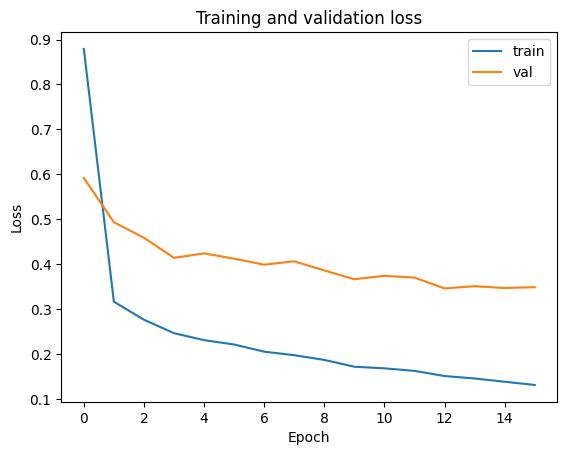

In [22]:
plt.figure()
plt.plot(train_losses, label = 'train')
plt.plot(val_losses, label = 'val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()